In [1]:
# SPFDM Assignment 1
# Luuk Oudshoorn and Willem-Jan de Voogd
# Fall 2020

In [2]:
import dx
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt
from glob import glob
from scipy.interpolate import interp1d
%matplotlib inline

Text(0, 0.5, 'Rate (%)')

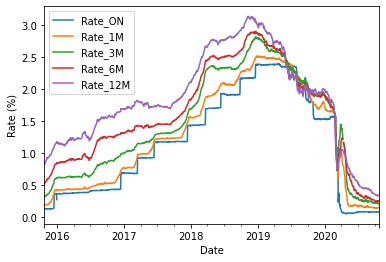

In [3]:
# Load LIBOR Rates
periods = ['ON','1M','3M','6M','12M']
LIBOR = pd.DataFrame()
for period in periods:
    filename = glob('./USD'+period+'*.csv')[0]
    LIBOR_sub = pd.read_csv(filename)
    LIBOR_sub['DATE'] = pd.to_datetime(LIBOR_sub['DATE'])
    LIBOR_sub.columns = ['Date','Rate_'+period]
    LIBOR_sub = LIBOR_sub.set_index('Date')
    LIBOR_sub = LIBOR_sub.replace('.',np.nan)
    LIBOR_sub['Rate_'+period] = LIBOR_sub['Rate_'+period].astype(float)
    LIBOR = pd.concat((LIBOR,LIBOR_sub),axis=1)
LIBOR.plot()
plt.ylabel('Rate (%)')

In [4]:
# Libor rates from ICE
# https://www.theice.com/marketdata/reports/170
#LIBOR = pd.DataFrame({'Name':['Rate_3M','Rate_6M','Rate_12M'],'Rate':[-0.52971,-0.52329,-0.47386]}).set_index('Name')
#LIBOR
# Latest libor rates
# These are annualized interest rates
LIBOR = pd.DataFrame({'Rate':LIBOR.iloc[-1,2:]})
LIBOR.loc['Rate_9M'] = interp1d([3,6,12],LIBOR.Rate,kind='linear')(9)

In [5]:
# OIS curve, is 0.1% lower than Libor curve assuming fixed spread
# We bootstrap the OIS for quarterly payments
OIS = (LIBOR -0.1).sort_index()
OIS

,Rate
Rate_12M,0.236630
Rate_3M,0.116500
Rate_6M,0.149380
Rate_9M,0.193005


In [6]:
# OIS is the first part of the zero curve
zerocurve = pd.DataFrame({'Years':[1,0.25,0.5,0.75],'Zero rate':OIS.values.flatten()})

zerocurve = zerocurve.set_index('Years').sort_index()
zerocurve
for i in np.arange(1.25,30.1,0.25):
    zerocurve.loc[i] = np.nan
zerocurve

,Zero rate
Years,
0.25,0.116500
0.50,0.149380
0.75,0.193005
1.00,0.236630
1.25,NaN
...,...
29.00,NaN
29.25,NaN
29.50,NaN


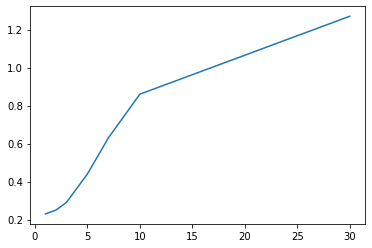

,Swap_Rate
Years,
1.00,0.230000
1.25,0.235000
1.50,0.240000
1.75,0.245000
2.00,0.250000
...,...
29.00,1.249500
29.25,1.254625
29.50,1.259750


In [7]:
# To obtain longer rates we need to bootstrap
# For bootstrapping we also need the swap rates. These are obtained from 
# http://www.interestrateswapstoday.com/swap-rates.html
def read_interp_swaprates():
    swaprates  =  pd.DataFrame({'Name':['1-Year','2-Year','3-Year','5-Year','7-Year','10-Year','30-Year'],'Rate':[0.230,0.25,0.29,0.44,0.63,0.86,1.270]}).set_index('Name')
    swaprates['NMonths'] = [12,24,36,60,84,120,360]
    #We need to interpolate swaprates to get all intermediate values
    to_interpolate = np.arange(12,361,3)
    # We use cubic interpolation as this generates a much smoother curve
    interpolated = interp1d(swaprates['NMonths'],swaprates['Rate'],kind='linear')(to_interpolate)
    swaprates_interp = pd.DataFrame({'Years':to_interpolate/12,'Swap_Rate':interpolated})
    return swaprates_interp.set_index('Years')
swaprates_interp = read_interp_swaprates()
plt.plot(swaprates_interp.index, swaprates_interp.Swap_Rate)
plt.show()
swaprates_interp

In [8]:
# Having both libor and swap rates we should be able to bootstrap the zero curve

In [9]:
def bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm):
    """Takes known discounting rates and known swap rate for some times
       and returns the swaprate for an unknown time"""
    # payterm = years between payments
    # discount rates = libor/ois like rates
    # swaprate is the at-par rate for the IRS
    # duration is the number of years of the swap
    
    Npayments = duration / payterm - 1 # because we estimate one
    # We loop through all payments except for the unknown
    swapvalue = 0
    for i,time in enumerate(disc_rates_times):
        if time != duration: # intermediate payouts
            payout = swaprate * payterm
        elif time ==duration: #final payout
            payout = swaprate * payterm + 100
        depreciation = np.exp(-time*disc_rates[i]/100)
        swapvalue += payout * depreciation
    # The swap is now worth par, thus 100. We calculate the rate solving the 
    # missing term
    
    if to_calculate == duration:
        # If we miss the last term, then divide by 100+coupon
        rate = np.log((100-swapvalue)/(swaprate * payterm + 100))/(-to_calculate)
    elif to_calculate != duration:
        # If we search for an intermediate term, divide by coupon
        rate = np.log((100-swapvalue)/(swaprate * payterm))/(-to_calculate)
    return (rate*100)

In [10]:
# Example from Hull
disc_rates = [4,4.5,4.8]
disc_rates_times = [0.5,1,1.5]
to_calculate = 2
swaprate   = 5
duration   = 2
payterm    = 0.5
bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm)

4.952932701412535

In [11]:
# Inverse problem of Hull; we know 0.5,1,2
disc_rates = [4,4.5,4.95293270]
disc_rates_times = [0.5,1,2]
to_calculate = 1.5
swaprate   = 5
duration   = 2
payterm    = 0.5
bootstrap(disc_rates, disc_rates_times,to_calculate, swaprate, duration, payterm)

4.800000075157118

In [12]:
# We have swap rates for all 3 month periods by interpolation
# Using each swap rate we can now equate the zero yield rate for that period
for years,row in zerocurve.iterrows():
    if (np.isnan(row['Zero rate'])):
        # Unknown rate, bootstrap!
        # Obtain swap rate for this maturity
        swaprate = swaprates_interp.loc[years].Swap_Rate
        known_rates = zerocurve.loc[:years-0.25]
        zerorate = bootstrap(known_rates.values,known_rates.index,years,
                             swaprate,years,0.25)
        zerocurve.loc[years] = zerorate


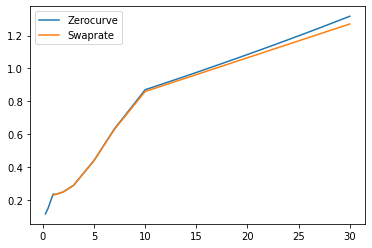

In [13]:
plt.plot(zerocurve.index, zerocurve.values,label='Zerocurve')
plt.plot(swaprates_interp.index, swaprates_interp.Swap_Rate,label='Swaprate')
plt.legend()

In [ ]:
# Now that we have the zerocurve, we can use it to valuate all kinds of IRS!

In [18]:
LIBOR

,Rate
Rate_3M,0.216500
Rate_6M,0.249380
Rate_12M,0.336630
Rate_9M,0.293005


In [29]:
zerocurve.loc[0.25] = 10
zerocurve.loc[0.5] = 10.5
zerocurve.loc[0.75] = 11
zerocurve.loc[1.00] = 11.5


In [52]:
class swaps():
    def __init__(self,start, lifetime,swaprate=None):
        """Initialize function. For any swap we determine
           its value as difference between long and short
           position in bonds. If inception if now, we solve
           this value such that it is zero.
           For each swap we pay fixed and receive floating rate
           
           start = float number of years, e.g. -0.5
           lifetime = total lifetime since inception, e.g. 5
           swaprate = some rate in % if defined. To find swaprate, 
           it should be set to None"""
        self.swapstart = start
        self.lifetime = lifetime
        self.swaprate=swaprate
        if self.swaprate:
            # We need to calculate the present day value
            # of this swap, since it already exists and has
            # a defined swaprate
            self.irsvalue = self.valuate()
        else:
            # We need to find the swaprate such that the net
            # present value equals zero
            self.getrate()
    
    def valuate(self):
        """We pay fixed and thus are short in fixed bond at 
           the swaprate r. We receive floating and are thus 
           long in floating bond."""
        # Fixed lag
        short = self.fixed_bond(self.swaprate)
        # Floating lag
        libor_float = 10.5
        long = self.floating_bond(libor_float)
        
        return short - long
        
    def fixed_bond(self,rate):
        time_remaining = self.lifetime - self.swapstart
        timesteps = np.arange(0.25,time_remaining,0.25)
        # Each step in timesteps, we get discounted floating rate
        # Additionally, we receive final payment
        value = 0
        for timestep in timesteps:
            discount_rate = zerocurve.loc[timestep].iloc[0]
            discount_factor = np.exp(-timestep*discount_rate/100)
            discounted_cash = (rate/4) * discount_factor
            value += discounted_cash
        # Final payment
        discount_rate = zerocurve.loc[time_remaining].iloc[0]
        discount_factor = np.exp(-time_remaining*discount_rate/100)
        value += (100+rate/4)*discount_factor
        return value
    
    def floating_bond(self,libor):
        """Floating bond is worth par after the first next payment
           and pays the LIBOR rate"""
        next_payment = 0.25
        discount_rate = zerocurve.loc[next_payment].iloc[0]
        discount_factor = np.exp(-next_payment*discount_rate/100)
        value = (100+libor * next_payment) * discount_factor
        return value
    
    #def get_rate(self):
        
swapper = swaps(0,1,8)      
    
swapper.irsvalue   
    
        
    

-3.4818817015289625